##  Amazon Fine Food Reviews Analysis

### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.
* Number of reviews: 568,454
* Number of users: 256,059
* Number of products: 74,258
* Timespan: Oct 1999 - Oct 2012
* Number of Attributes/Columns in data: 10

### Attribute Information:
* Id
* ProductId - unique identifier for the product
* UserId - unqiue identifier for the user
* ProfileName
* HelpfulnessNumerator - number of users who found the review helpful
* HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
* Score - rating between 1 and 5
* Time - timestamp for the review
* Summary - brief summary of the review
* Text - text of the review

### Objective:

* Find the right hyperparameter (C and gamma)  for all bow, tf-idf, avg w2v, tf-idf w2v using GridSearchCV and RandomSearchCV.


### Importing the libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string
import sqlite3
import re
import pickle
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

### Loading the Dataset

In [2]:
con = sqlite3.connect('F:/Applied AI Course/Amazon fine food review dataset/database.sqlite')

In [3]:
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

### Removing the duplicates

In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
final.shape

(364171, 10)

In [7]:
final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True,inplace=False).reset_index(drop=True)

In [8]:
final.shape

(364171, 10)

### Creating a subset of the data

In [9]:
final=final.iloc[:100000,:]

In [118]:
import re
import nltk
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
stop = set(stopwords.words('english'))

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub('[^A-Za-z0-9]+','',sentence)
    return  cleaned


In [11]:
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [12]:
final['CleanedText']=final_string

In [13]:
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [14]:
final.to_pickle('100k_svm_data.pkl')

In [172]:
final=pd.read_pickle('100k_svm_data.pkl')

In [173]:
X = final["CleanedText"]
y = final["Score"]

### Train Test Split

In [174]:
import math
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

print(X_1.shape,y_1.shape,X_test.shape)

(80000,) (80000,) (20000,)


In [175]:
X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape)

(60000,) (60000,) (20000,)


### Bag of Words (BoW) Vectorization Technique

In [176]:
count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train)

In [177]:
X_test = count_vect.transform(X_test)
X_CV=count_vect.transform(X_CV)

In [178]:
X_train

<60000x46451 sparse matrix of type '<class 'numpy.int64'>'
	with 1802857 stored elements in Compressed Sparse Row format>

In [179]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False)
standardized_train=standardized_data.fit_transform(X_train)
standardized_test=standardized_data.transform(X_test)
standardized_CV=standardized_data.transform(X_CV)

###  Calculate 'alpha' using CV

In [180]:
from sklearn.linear_model import SGDClassifier

alpha=[500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
cv_scores = []    
for i in alpha:
    
    sgd = SGDClassifier(alpha=i,class_weight='balanced')

    # fitting the model on crossvalidation train
    sgd.fit(standardized_train, y_train)

    # predict the response on the crossvalidation train
    pred = sgd.predict(standardized_CV)

    # evaluate CV f1-score
    f1 = f1_score(y_CV, pred, average='weighted') * float(100)
    cv_scores.append(f1)
        
    

In [181]:
scores = [x for x in cv_scores]

In [182]:
optimal_alpha = alpha[scores.index(max(scores))]
print('\nThe optimal value is %f.' % optimal_alpha)


The optimal value is 1.000000.


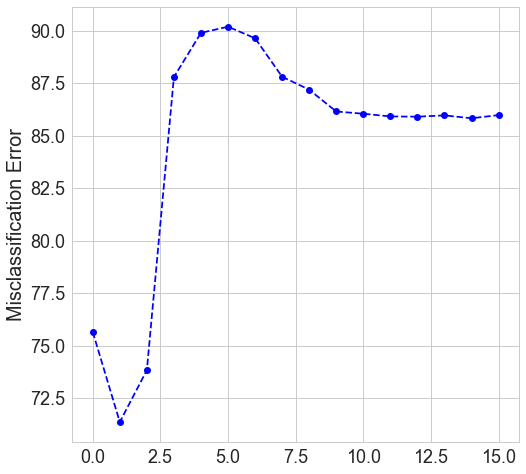

In [183]:
import seaborn as sns
sns.set_style("whitegrid")

plt.figure(figsize=(8,8))
plt.plot( scores,'--bo')
plt.rcParams.update({'font.size': 15})


plt.ylabel('Misclassification Error')
plt.show()

In [15]:
import seaborn as sns

Accuracy on test set: 89.805%
Precision on test set: 0.593
Recall on test set: 0.762
F1-Score on test set: 0.667
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



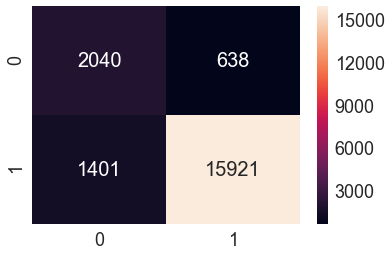

In [50]:
clf = SGDClassifier(alpha=1,penalty='l2',class_weight='balanced')
clf.fit(standardized_train,y_train)
y_pred = clf.predict(standardized_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

In [51]:
all_features=count_vect.get_feature_names()
all_nd_features=np.array(all_features)

In [52]:
w=clf.coef_

In [57]:
w=w.tolist()

In [68]:
from math import fabs
negative_abs=[fabs(x) for x in negative_w]


In [70]:
feature_dict=dict(zip(all_nd_features,w[0]))

In [73]:
feature_dict_positive = {k:v for k,v in feature_dict.items() if v >0.0}

In [76]:
top_100_positive_features=sorted(feature_dict_positive, key=feature_dict_positive.get, reverse=True)[:100]

In [78]:
feature_dict_negative = {k:v for k,v in feature_dict.items() if v <=0.0}

In [89]:
feature_dict_negative = dict()
for k,v in feature_dict.items():
    feature_dict_negative.update({k:fabs(v)})

In [90]:
top_100_negative_features=sorted(feature_dict_negative, key=feature_dict_negative.get, reverse=True)[:100]

In [80]:
from collections import Counter
from wordcloud import WordCloud

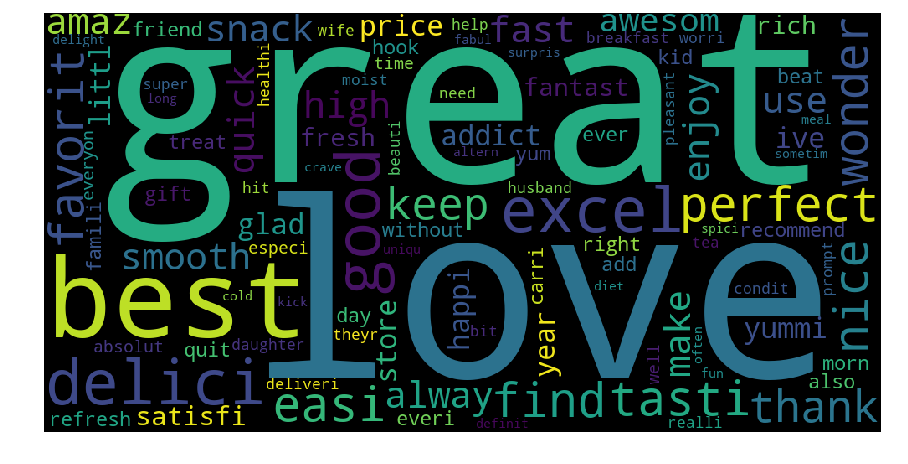

In [81]:
word_could_dict=Counter(top_100_positive_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

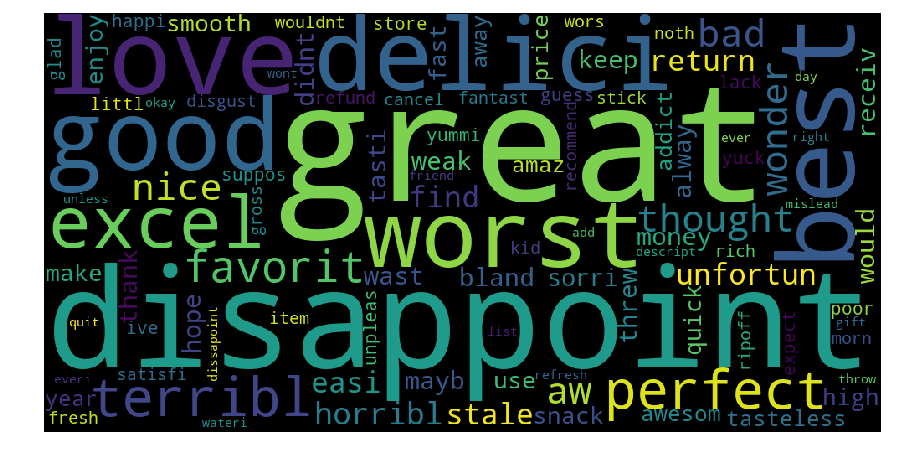

In [91]:
word_could_dict=Counter(top_100_negative_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

###  Calculate 'C' and 'gamma' using GridSearchCV

In [161]:
from gensim.models import Word2Vec
import math
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]


In [168]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

clf = SVC(class_weight='balanced')
param_grid = {'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier

gsv = GridSearchCV(clf,param_grid,scoring='f1_weighted',verbose=1,n_jobs=-1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 225 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:  3.9min finished


Best HyperParameter:  {'C': 50, 'gamma': 0.0005}
Wall time: 3min 55s


Accuracy on test set: 80.250%
Precision on test set: 0.889
Recall on test set: 0.093
F1-Score on test set: 0.168
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



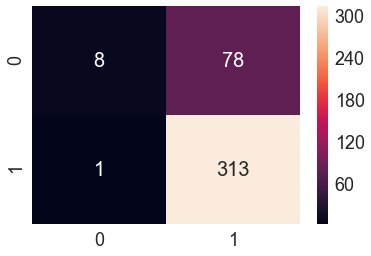

In [169]:
clf = SVC(C=50,gamma=0.0005)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

###  Calculate 'C' and 'gamma' using RandomizedSearchCV

In [170]:
%%time
from sklearn.model_selection import RandomizedSearchCV


clf = SVC(class_weight='balanced')
#params we need to try on classifier
param_dist = {'gamma':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} 

gsv = RandomizedSearchCV(clf,param_dist,scoring='f1_weighted',verbose=1,n_iter=15)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   39.6s finished


Best HyperParameter:  {'gamma': 0.005, 'C': 5}
Wall time: 40.1 s


Accuracy on test set: 79.250%
Precision on test set: 1.000
Recall on test set: 0.035
F1-Score on test set: 0.067
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



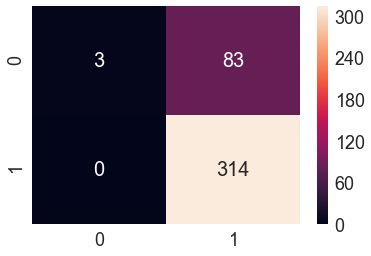

In [171]:
clf = SVC(C=5,gamma=0.005)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

### tf-idf Vectorization Technique

In [184]:
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

print(X_1.shape,y_1.shape,X_test.shape)

(80000,) (80000,) (20000,)


In [185]:
X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape)

(60000,) (60000,) (20000,)


In [186]:
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)

In [187]:
X_test=tf_idf_vect.transform(X_test)
X_CV=tf_idf_vect.transform(X_CV)

In [188]:
X_train

<60000x46451 sparse matrix of type '<class 'numpy.float64'>'
	with 1802857 stored elements in Compressed Sparse Row format>

In [189]:
standardized_data = StandardScaler(with_mean=False)
standardized_train=standardized_data.fit_transform(X_train)
standardized_test=standardized_data.transform(X_test)
standardized_CV=standardized_data.transform(X_CV)

###  Calculate 'alpha' using CV

In [190]:
alpha=[500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
cv_scores = []    
for i in alpha:
    
    sgd = SGDClassifier(alpha=i,class_weight='balanced')

    # fitting the model on crossvalidation train
    sgd.fit(standardized_train, y_train)

    # predict the response on the crossvalidation train
    pred = sgd.predict(standardized_CV)

    # evaluate CV accuracy
    f1_value = f1_score(y_CV, pred, average='weighted') * float(100)
    cv_scores.append(f1_value)
    

In [191]:
scores= [x for x in cv_scores]

In [192]:
optimal_alpha = alpha[scores.index(max(scores))]
print('\nThe optimal value is %f.' % optimal_alpha)


The optimal value is 5.000000.


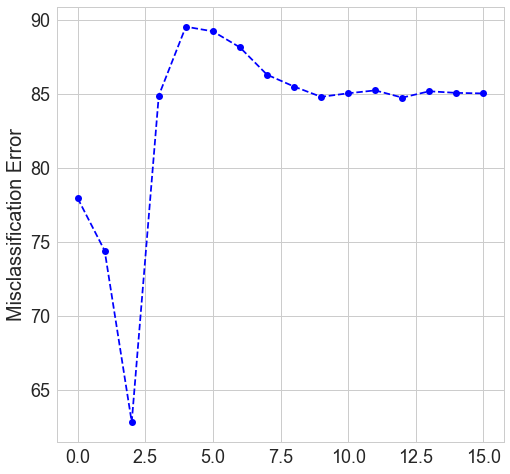

In [193]:
sns.set_style("whitegrid")

plt.figure(figsize=(8,8))
plt.plot(scores,'--bo')
plt.rcParams.update({'font.size': 15})


plt.ylabel('Misclassification Error')
plt.show()

Accuracy on test set: 88.980%
Precision on test set: 0.567
Recall on test set: 0.749
F1-Score on test set: 0.645
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



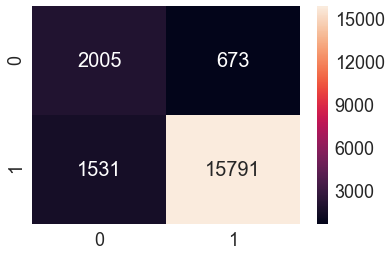

In [104]:
clf = SGDClassifier(alpha=5,penalty='l2',class_weight='balanced')
clf.fit(standardized_train,y_train)
y_pred = clf.predict(standardized_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

In [105]:
all_features=tf_idf_vect.get_feature_names()
all_nd_features=np.array(all_features)

In [106]:
w1 = clf.coef_

In [107]:
w1=w1.tolist()

In [108]:
feature_dict=dict(zip(all_nd_features,w1[0]))

In [109]:
feature_dict_positive = {k:v for k,v in feature_dict.items() if v >0.0}

In [110]:
top_100_positive_features=sorted(feature_dict_positive, key=feature_dict_positive.get, reverse=True)[:100]

In [111]:
feature_dict_negative = {k:v for k,v in feature_dict.items() if v <=0.0}

In [112]:
feature_dict_negative = dict()
for k,v in feature_dict.items():
    feature_dict_negative.update({k:fabs(v)})

In [113]:
top_100_negative_features=sorted(feature_dict_negative, key=feature_dict_negative.get, reverse=True)[:100]

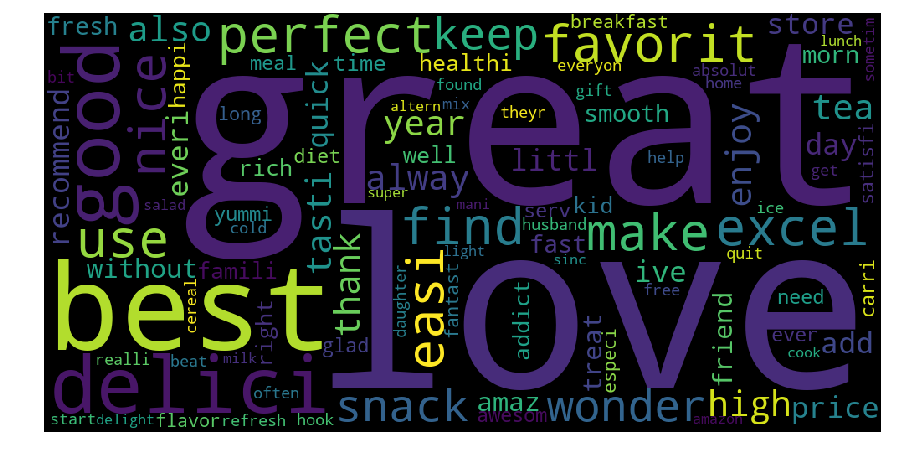

In [114]:
word_could_dict=Counter(top_100_positive_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

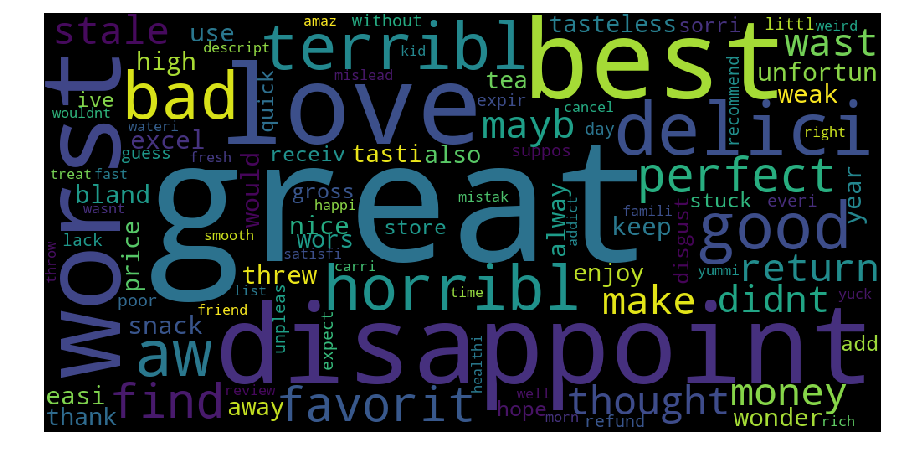

In [115]:
word_could_dict=Counter(top_100_negative_features)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off") 
plt.show()

### W2V Vectorization Technique

In [136]:
from gensim.models import Word2Vec
import math
X_1=X[:math.ceil(len(final)*.8)]
y_1=y[:math.ceil(len(final)*.8)]
X_test=X[math.ceil(len(final)*.8):]
y_test=y[math.ceil(len(final)*.8):]

X_train=X_1[:math.ceil(len(final)*.6)]
y_train=y_1[:math.ceil(len(final)*.6)]
X_CV=X_1[math.ceil(len(final)*.6):]
y_CV=y_1[math.ceil(len(final)*.6):]

print(X_train.shape,y_train.shape,X_CV.shape,X_test.shape)

(60000,) (60000,) (20000,) (20000,)


In [119]:
# Train your own Word2Vec model using your own train corpus
import gensim


list_of_sent=[]
    
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [120]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [121]:
w2v = list(w2v_model.wv.vocab)

In [122]:
print("number of words that occured minimum 5 times ",len(w2v))

number of words that occured minimum 5 times  10609


### Average W2V

In [123]:
# average Word2Vec
# compute average word2vec for each review.
from tqdm import tqdm
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_train.values): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [02:33<00:00, 391.89it/s]


60000
50


In [124]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:59<00:00, 336.36it/s]


20000
50


In [125]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_CV = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_CV): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_CV.append(sent_vec)
print(len(sent_vectors_CV))
print(len(sent_vectors_CV[0]))

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:54<00:00, 365.62it/s]


20000
50


In [126]:
X_train = sent_vectors
X_test = sent_vectors_test
X_CV= sent_vectors_CV

###  Calculate 'alpha'  using CV

In [127]:
alpha=[500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
cv_scores = []    
for i in alpha:
    
    sgd = SGDClassifier(alpha=i,class_weight='balanced')

    # fitting the model on crossvalidation train
    sgd.fit(X_train, y_train)

    # predict the response on the crossvalidation train
    pred = sgd.predict(X_CV)

    # evaluate CV accuracy
    f1_value = f1_score(y_CV, pred, average='weighted') * float(100)
    cv_scores.append(f1_value)

In [128]:
scores = [x for x in cv_scores]

In [129]:
optimal_alpha = alpha[scores.index(max(scores))]
print('\nThe optimal value is %f.' % optimal_alpha)


The optimal value is 0.000010.


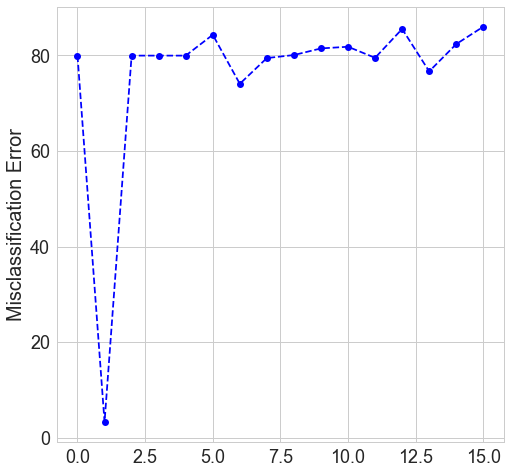

In [133]:
sns.set_style("whitegrid")

plt.figure(figsize=(8,8))
plt.plot(scores,'--bo')
plt.rcParams.update({'font.size': 15})


plt.ylabel('Misclassification Error')
plt.show()

Accuracy on test set: 82.020%
Precision on test set: 0.400
Recall on test set: 0.683
F1-Score on test set: 0.504
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



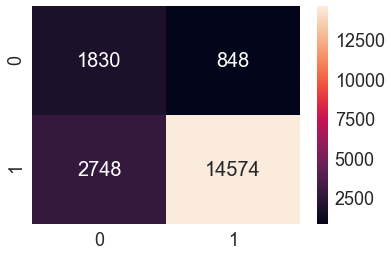

In [134]:
clf = SGDClassifier(alpha=0.000010,penalty='l2',class_weight='balanced')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

### tf-idf W2V Vectorization Technique

In [137]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [138]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_train.values): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [03:07<00:00, 319.61it/s]


In [139]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:07<00:00, 298.14it/s]


In [140]:
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_CV): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent.split(): # for each word in a review/sentence
        if word in w2v:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:12<00:00, 275.50it/s]


In [141]:
X_train = tfidf_sent_vectors
X_test = tfidf_sent_vectors_test
X_CV=tfidf_sent_vectors_CV

###  Calculate 'alpha'  using CV

In [142]:
alpha=[500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
cv_scores = []    
for i in alpha:
    
    sgd = SGDClassifier(alpha=i,class_weight='balanced')

    # fitting the model on crossvalidation train
    sgd.fit(X_train, y_train)

    # predict the response on the crossvalidation train
    pred = sgd.predict(X_CV)

    # evaluate CV accuracy
    f1_value = f1_score(y_CV, pred, average='weighted') * float(100)
    cv_scores.append(f1_value)
    

In [60]:
scores = [ x for x in cv_scores]

In [143]:
optimal_alpha = alpha[scores.index(max(scores))]
print('\nThe optimal number of neighbors is %f.' % optimal_alpha)


The optimal number of neighbors is 0.000010.


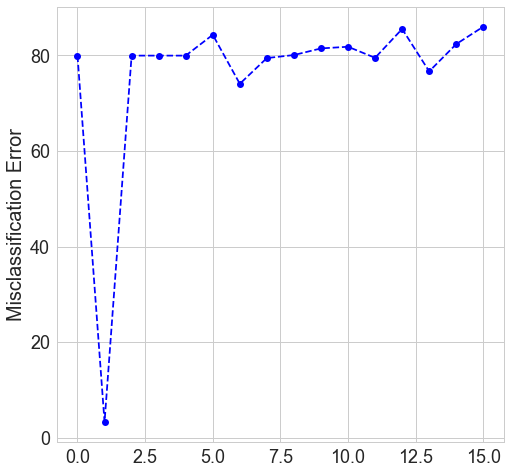

In [144]:
sns.set_style("whitegrid")

plt.figure(figsize=(8,8))
plt.plot(scores,'--bo')
plt.rcParams.update({'font.size': 15})


plt.ylabel('Misclassification Error')
plt.show()

Accuracy on test set: 67.705%
Precision on test set: 0.256
Recall on test set: 0.739
F1-Score on test set: 0.380
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



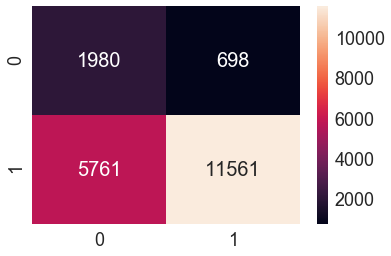

In [148]:
clf = SGDClassifier(alpha=0.000010,penalty='l2',class_weight='balanced')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred, pos_label="negative")))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred, pos_label="negative")))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred, pos_label="negative")))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.8)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20}, fmt='g')
plt.show()

In [145]:
from prettytable import PrettyTable
    
x = PrettyTable()

In [146]:
x.field_names = ["Vectorization_Technique", "Best alpha", "F1-Score", "Accuracy(%)"]

In [149]:
x.add_row(["BOW", "1" , 0.667, 89.805 ])

In [150]:
x.add_row(["tf-idf", "5" ,0.645, 88.980])

In [151]:
x.add_row(["Average W2V", "0.000010" ,0.504, 82.020])

In [152]:
x.add_row(["tf-idf W2V","0.000010" ,0.380, 67.705])

In [153]:
print(x)

+-------------------------+------------+----------+-------------+
| Vectorization_Technique | Best alpha | F1-Score | Accuracy(%) |
+-------------------------+------------+----------+-------------+
|           BOW           |     1      |  0.667   |    89.805   |
|          tf-idf         |     5      |  0.645   |    88.98    |
|       Average W2V       |  0.000010  |  0.504   |    82.02    |
|        tf-idf W2V       |  0.000010  |   0.38   |    67.705   |
+-------------------------+------------+----------+-------------+


## Conclusions

1. BOW Featurization gave the best results with accuracy of 89.805% and F1-score of 0.667
2. Perform SVC with BOW featurization(due to best result).